In [1]:
import numpy as np
#import urllib
import urllib.request
import cv2
import json
import requests
import os
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
barcodes=["Z255414503"] #Z255414503

In [5]:
def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  return image

In [6]:
def getManifest(barcode):
    operUrl = urllib.request.urlopen("https://iiif.onb.ac.at/presentation/ABO/"+barcode+"/manifest/")
    data = operUrl.read()
    jsonData = json.loads(data)
    return jsonData

In [7]:
def getNumpages(manifest):
    return len(manifest["sequences"][0]["canvases"])

In [8]:
def getpngurl(b):
  np = getNumpages(getManifest(b))
  for n in range(np):
    pn = format(n + 1,'08d')
    url = "https://iiif.onb.ac.at/images/ABO/"+b+"/"+str(pn)+"/full/full/0/native.jpg" #"/full/180,180/0/native.jpg"
    urls_t.append(url)
    #print (url)

In [9]:
model = tf.keras.models.load_model('zeidm_v2.h5') #path to model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0

In [10]:
urls_t = []

In [11]:
for bc in barcodes:
  getpngurl(bc)

In [12]:
len(urls_t)

432

In [13]:
test_data = list()
for url in urls_t: #[0:2]
    image = url_to_image(url)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image/255.0  , (180 , 180))
    image = np.expand_dims(image, axis=0)
    test_data.append(image)

In [14]:
preds = []
for i in test_data:
  pred = model.predict(i)
  preds.append(pred)

In [15]:
preds = np.array(preds, dtype=np.float32)

In [16]:
# Round the probabilities to 0 and 1
preds = preds.round(0).astype(int)

# Split to class_0 (pred=0) and class_1 (pred=1). 
class_0 = np.where(preds.reshape(preds.shape[0]) == 0)[0]
class_1 = np.where(preds.reshape(preds.shape[0]) == 1)[0]

In [17]:
class_0

array([  6,  14,  27,  54, 114, 177, 237, 243, 280, 292, 340, 368, 386,
       425, 426])

In [18]:
class_1

array([  0,   1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 18

In [19]:
class_0_images = []
for item in enumerate(class_0):
    class_0_images.append(test_data[item[1]])
    
ill = np.array(class_0_images)
ill = ill.reshape(ill.shape[0],180,180,3)

In [20]:
class_1_images = []
for item in enumerate(class_1):
    class_1_images.append(test_data[item[1]])

noill = np.array(class_1_images)
noill = noill.reshape(noill.shape[0],180,180,3)

In [21]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  num_images = image_batch.shape[0]
  num_rows = np.ceil(num_images/5)
  for n in range(num_images):
      ax = plt.subplot(num_rows,5, n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch)
      plt.axis('off')

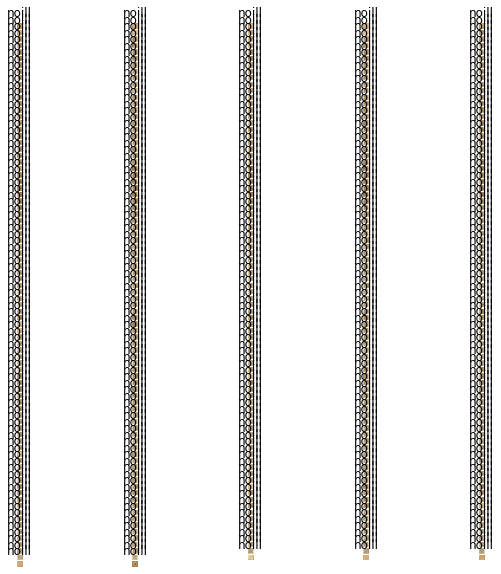

In [22]:
show_batch(noill, 'noill')

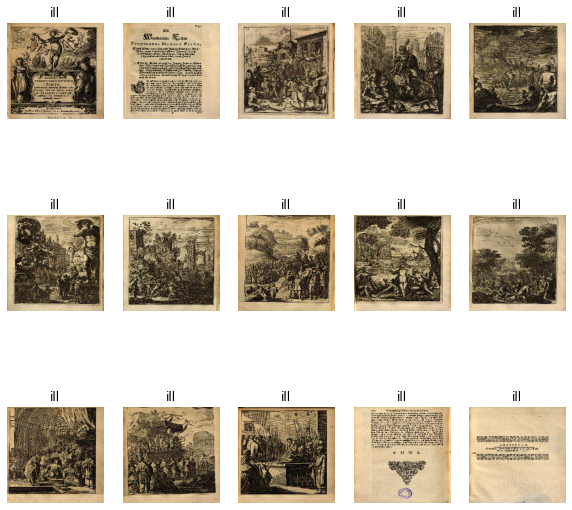

In [23]:
show_batch(ill, 'ill')